In [1]:
import numpy
import pandas as pd
from colormath import color_objects, color_diff
import math

def patch_asscalar(a):
    return a.item()
setattr(numpy, "asscalar", patch_asscalar)

color_df = pd.read_csv("all_colors.csv")

lab_string = list(color_df["L*a*b Value"])
lab_strings = [color_string.split(", ") for color_string in lab_string]

lab_floats = [[float(x) for x in row] for row in lab_strings]

lab_colors = [color_objects.LabColor(lab_l=lab_color[0], lab_a=lab_color[1], lab_b=lab_color[2]) for lab_color in lab_floats]

distance_matrix = {}
for i, color1 in enumerate(lab_colors):
    for j, color2 in enumerate(lab_colors):
        if i != j:
            distance_matrix[(i, j)] = round(color_diff.delta_e_cie2000(color1=color1, color2=color2) * 10)
            #distance_matrix[(i, j)] = round(math.dist((color1.lab_l, color1.lab_a, color1.lab_b),(color2.lab_l, color2.lab_a, color2.lab_b))*10)

In [ ]:
from ortools.sat.python import cp_model

model = cp_model.CpModel()

num_colors = 103
num_colors_to_select = 17

# x[c] = 1 if color c is selected
x = {c: model.NewBoolVar(f'select_color_{c}') for c in range(num_colors)}

# Constraint: Select exactly 17 colors
model.Add(sum(x[c] for c in range(num_colors)) == num_colors_to_select)

# Objective: Maximize total pairwise distance
objective_terms = []
for i in range(num_colors):
    for j in range(i + 1, num_colors):
        if (i, j) in distance_matrix:
            dist = distance_matrix[(i, j)]
        elif (j, i) in distance_matrix:
            dist = distance_matrix[(j, i)]
        else:
            continue
        
        # pair_var = 1 if both x[i] and x[j] are selected
        pair_var = model.NewBoolVar(f'pair_{i}_{j}')
        model.AddBoolAnd([x[i], x[j]]).OnlyEnforceIf(pair_var)
        model.AddBoolOr([x[i].Not(), x[j].Not()]).OnlyEnforceIf(pair_var.Not())
        
        objective_terms.append(dist * pair_var)

model.Maximize(sum(objective_terms))

# Solve
solver = cp_model.CpSolver()
solver.parameters.log_search_progress = True 
solver.parameters.num_workers = 8
solver.parameters.max_time_in_seconds = 15  # Optional time limit
status = solver.Solve(model)

# Extract results
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    selected_colors = [c for c in range(num_colors) if solver.Value(x[c]) == 1]
    
    # Calculate average distance
    total_dist = 0
    count = 0
    for i in selected_colors:
        for j in selected_colors:
            if i < j:
                dist = distance_matrix.get((i, j)) or distance_matrix.get((j, i), 0)
                total_dist += dist
                count += 1
    
    avg_dist = total_dist / count if count > 0 else 0
    print(f"Selected colors: {selected_colors}")
    print(f"Average distance: {avg_dist / 10}")
    print(f"Status: {'OPTIMAL' if status == cp_model.OPTIMAL else 'FEASIBLE'}")
else:
    print(f"Solver failed with status: {solver.StatusName(status)}")


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 15 log_search_progress: true num_workers: 8

Initial optimization model '': (model_fingerprint: 0x4639bd4a1378b495)
#Variables: 5'356 (#bools: 5'253 in objective) (5'355 primary variables)
  - 5'356 Booleans in [0,1]
#kBoolAnd: 5'253 (#enforced: 5'253) (#literals: 15'759)
#kBoolOr: 5'253 (#enforced: 5'253) (#literals: 10'506)
#kLinearN: 1 (#terms: 103)

Starting presolve at 0.00s
  1.14e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.65e-03s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  1.70e-05s  0.00e+00d  [ExtractEncodingFromLinear] 
  1.03e-04s  0.00e+00d  [DetectDuplicateColumns] 
  1.11e-03s  0.00e+00d  [DetectDuplicateConstraints] 
[Symmetry] Graph for symmetry has 21'322 nodes and 47'586 arcs.
[Symmetry] Symmetry computation done. time: 0.002055 dtime: 0.00585536
[SAT presolve] num removable Booleans: 0 / 5356
[SAT presolve] num trivial clauses: 0
[SAT presolve] [0s] clauses:15759 

In [3]:
selected_colors = [6, 12, 16, 18, 19, 24, 30, 35, 37, 46, 47, 49, 53, 62, 72, 88, 102]
import random

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def print_color_block_hex(hex_color, text="    "):
    r, g, b = hex_to_rgb(hex_color)
    print(f"\033[48;2;{r};{g};{b}m{text}\033[0m", end="")

hex_codes = [color_df.iloc[color]['Hex'] for color in selected_colors]

random.shuffle(hex_codes)

for hex_color in hex_codes:
    print_color_block_hex(hex_color)

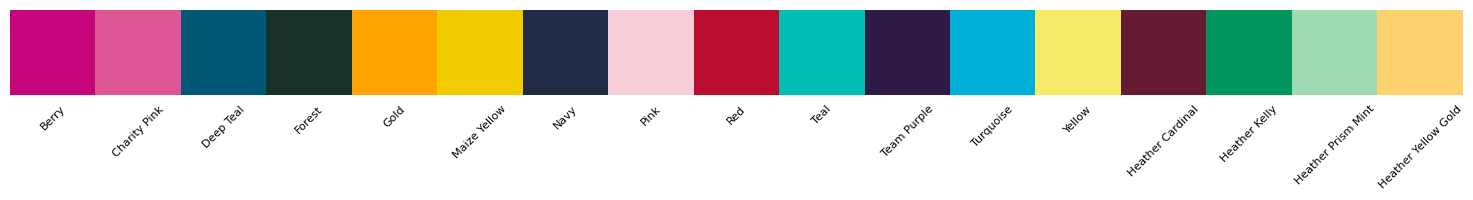

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_palette(hex_colors, color_names=None):
    n = len(hex_colors)
    fig, ax = plt.subplots(1, 1, figsize=(n * 1.2, 2))
    
    for i, hex_color in enumerate(hex_colors):
        rect = patches.Rectangle((i, 0), 1, 1, facecolor='#'+hex_color)
        ax.add_patch(rect)
        if color_names:
            ax.text(i + 0.5, -0.1, color_names[i], ha='center', va='top', 
                    fontsize=8, rotation=45)
    
    ax.set_xlim(0, n)
    ax.set_ylim(-0.5 if color_names else 0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

hex_codes = [color_df.iloc[c]['Hex'] for c in selected_colors]
names = [color_df.iloc[c]['Color Name'] for c in selected_colors]
display_palette(hex_codes, names)

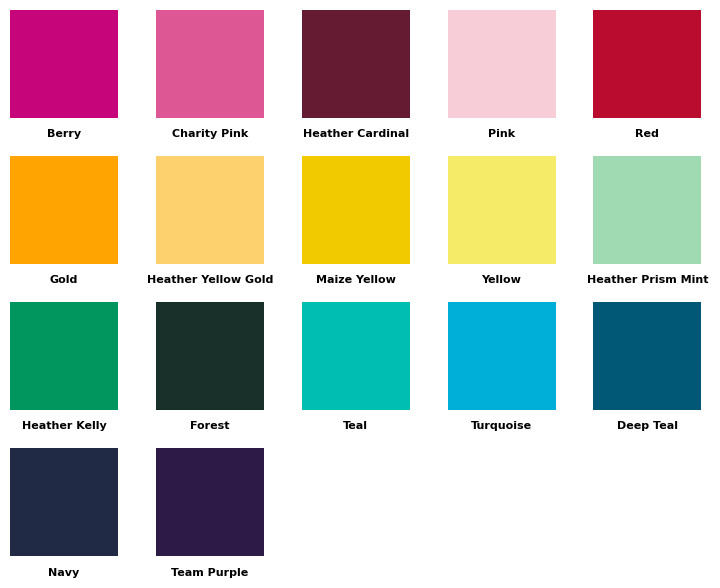

In [42]:
def display_palette(hex_colors, color_names=None, cols=None):
    n = len(hex_colors)
    # Default to square-ish grid
    if cols is None:
        cols = int(n ** 0.5) + (1 if n % int(n ** 0.5) else 0)
    rows = (n + cols - 1) // cols
    
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    
    # Handle case where we only have 1 subplot
    if rows == 1 and cols == 1:
        ax = [[ax]]
    elif rows == 1 or cols == 1:
        ax = ax.reshape(rows, cols)
    
    for idx, hex_color in enumerate(hex_colors):
        row = idx // cols
        col = idx % cols
        subplot_ax = ax[row, col]
        
        rect = patches.Rectangle((0, 0), 1, 1, facecolor='#'+hex_color)
        subplot_ax.add_patch(rect)
        
        if color_names:
            subplot_ax.text(0.5, -0.1, color_names[idx], ha='center', va='top', 
                           fontsize=8, fontweight='bold')
        
        subplot_ax.set_xlim(0, 1)
        subplot_ax.set_ylim(-0.2 if color_names else 0, 1)
        subplot_ax.set_aspect('equal')
        subplot_ax.axis('off')
    
    # Hide empty subplots
    for idx in range(n, rows * cols):
        row = idx // cols
        col = idx % cols
        ax[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig("assets/testgrid.svg")
    plt.show()

hex_codes = [color_df.iloc[c]['Hex'] for c in selected_colors]
names = [color_df.iloc[c]['Color Name'] for c in selected_colors]
display_palette(hex_codes, names)  # Uses default square-ish grid
# Or specify columns: display_palette(hex_codes, names, cols=6)

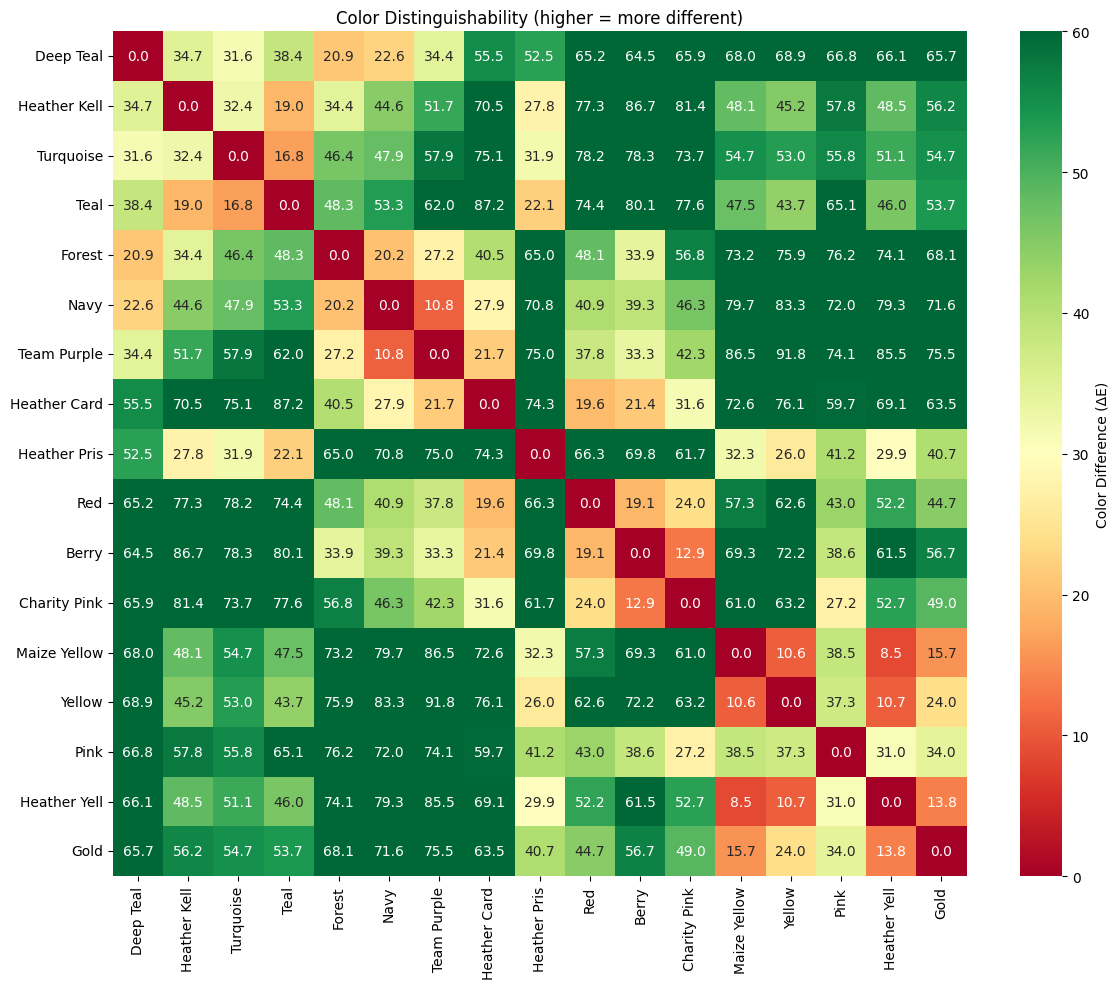

In [9]:
import seaborn as sns

selected_colors.sort(key=lambda c: color_df.iloc[c]['Hex'])

def plot_distance_heatmap(selected_colors, distance_matrix, color_df):
    n = len(selected_colors)
    names = [color_df.iloc[c]['Color Name'][:12] for c in selected_colors]
    
    # Build distance matrix for selected colors
    matrix = []
    for i in selected_colors:
        row = []
        for j in selected_colors:
            if i == j:
                row.append(0)
            else:
                dist = distance_matrix.get((i, j)) or distance_matrix.get((j, i), 0)
                row.append(dist / 10)  # Convert back to CIE units
        matrix.append(row)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, xticklabels=names, yticklabels=names, 
                annot=True, fmt='.1f', cmap='RdYlGn', 
                vmin=0, vmax=60, cbar_kws={'label': 'Color Difference (ΔE)'})
    plt.title('Color Distinguishability (higher = more different)')
    plt.tight_layout()
    plt.show()

plot_distance_heatmap(selected_colors, distance_matrix, color_df)

In [39]:
from colorsys import rgb_to_hsv

def hex_to_hsv(hex_color):
    """Convert hex color to HSV tuple (hue, saturation, value)"""
    hex_color = hex_color.lstrip('#')
    r, g, b = [int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4)]
    h, s, v = rgb_to_hsv(r, g, b)
    return (h, s, v)

def adjust_hue_for_rainbow(hex_color):
    """Adjust hue so red starts at beginning (red -> yellow -> green -> blue -> magenta -> red)"""
    h, s, v = hex_to_hsv(hex_color)
    # Rotate hue by -0.1 so red (which is ~0) starts first
    h = (h + 0.15) % 1.0
    return (h, s, v)

# Sort by adjusted hue (creates rainbow order starting with red)
selected_colors.sort(key=lambda c: adjust_hue_for_rainbow(color_df.iloc[c]['Hex']))

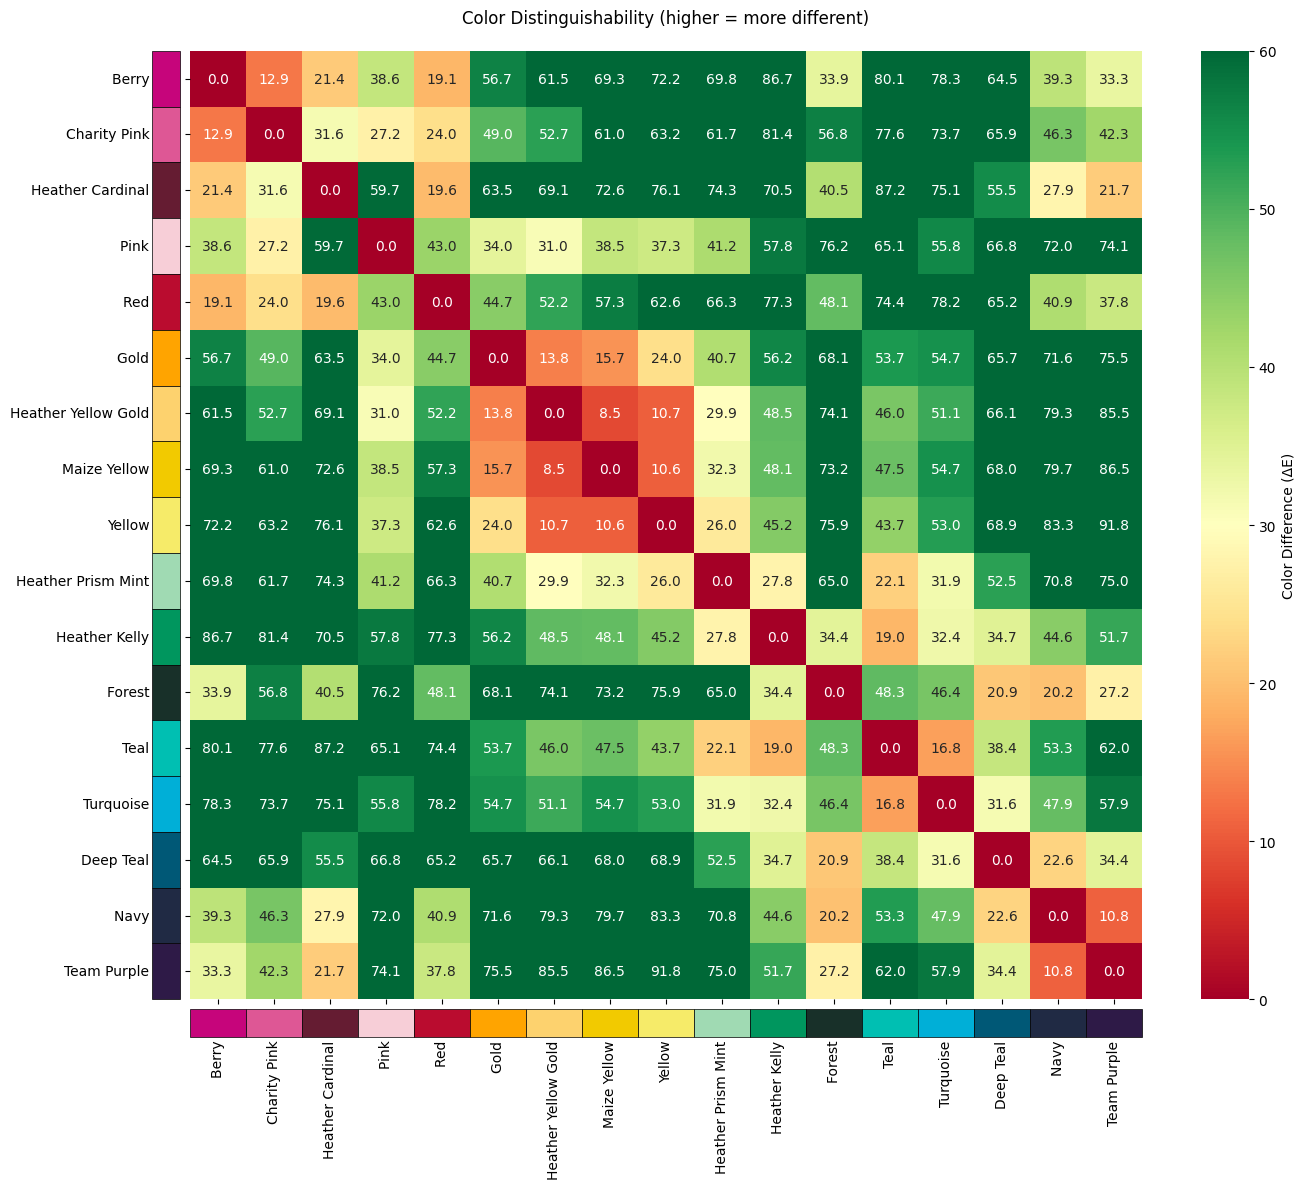

In [40]:
import seaborn as sns
import matplotlib.patches as mpatches

def plot_distance_heatmap(selected_colors, distance_matrix, color_df):
    n = len(selected_colors)
    names = [color_df.iloc[c]['Color Name'] + " "*7 for c in selected_colors]
    hex_colors = [color_df.iloc[c]['Hex'] for c in selected_colors]
    
    # Build distance matrix for selected colors
    matrix = []
    for i in selected_colors:
        row = []
        for j in selected_colors:
            if i == j:
                row.append(0)
            else:
                dist = distance_matrix.get((i, j)) or distance_matrix.get((j, i), 0)
                row.append(dist / 10)
        matrix.append(row)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(matrix, xticklabels=names, yticklabels=names, 
                annot=True, fmt='.1f', cmap='RdYlGn', 
                vmin=0, vmax=60, cbar_kws={'label': 'Color Difference (ΔE)'},
                ax=ax)
    
    # Add color swatches to y-axis (left side)
    for i, hex_color in enumerate(hex_colors):
        rect = mpatches.Rectangle((-0.04, (n - i - 1) / n), 0.03, 1 / n, 
                                  facecolor='#' + hex_color, edgecolor='black', linewidth=0.5,
                                  transform=ax.transAxes, clip_on=False)
        ax.add_patch(rect)
    
    # Add color swatches to x-axis (top side) - using figure coordinates
    for i, hex_color in enumerate(hex_colors):
        rect = mpatches.Rectangle((i / n, -0.04), 1 / n, 0.03,
                                  facecolor='#' + hex_color, edgecolor='black', linewidth=0.5,
                                  transform=ax.transAxes, clip_on=False)
        ax.add_patch(rect)
    
    ax.set_title('Color Distinguishability (higher = more different)', pad=20)
    plt.tight_layout()
    plt.show()

plot_distance_heatmap(selected_colors, distance_matrix, color_df)